<a href="https://colab.research.google.com/github/EvaEVL/BodySegmentation/blob/main/bodysegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os
import tqdm

import shutil 
from tqdm import tqdm

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models
import torch.nn as nn
import torchvision.transforms.functional as TF

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# !kaggle datasets download -d awsaf49/coco-2017-dataset
!kaggle datasets download -d tapakah68/segmentation-full-body-mads-dataset

100% 473M/474M [00:03<00:00, 182MB/s]
100% 474M/474M [00:03<00:00, 157MB/s]


In [ ]:
!unzip /content/segmentation-full-body-mads-dataset.zip

In [8]:
data_root = '/content/segmentation_full_body_mads_dataset_1192_img'
image_path = data_root + '/images'
mask_path = data_root + '/masks'
print(os.listdir(data_root))

['images', 'collages', 'masks']


In [9]:
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision.io import read_image
import glob
from torchvision import io, transforms

import matplotlib.pyplot as plt
import random

In [10]:
IMAGE_SIZE = (224, 224)


class SegData(Dataset):
    def __init__(self, root_path, transform=None):
        super().__init__()
        
        self.transform = transform
        self.img_files = glob.glob(os.path.join(root_path,'images','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(root_path,'masks',os.path.basename(img_path)))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        image_path = self.img_files[index]
        mask_path  = self.mask_files[index]
        image = read_image(image_path)
        mask = read_image(mask_path, mode = io.ImageReadMode(1))#read mode 1 - Gray
        
        if self.transform:
            image, mask = self.transform(image, mask)
            
        return image, mask

def transform(img1, img2):
    
    
    # Random horizontal flipping
#     if random.random() > 0.5:
#         img1 = TF.hflip(img1)
#         img2 = TF.hflip(img2)
    
    params = transforms.RandomResizedCrop.get_params(img1, scale=(0.5, 1.0), ratio=(0.75, 1.33))
    img1 = TF.resized_crop(img1, *params, size=IMAGE_SIZE)
    img2 = TF.resized_crop(img2, *params, size=IMAGE_SIZE)

    
    train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img1 = train_transforms(img1)
    
    img2 = img2.to(torch.float) / 255
    
    return img1, img2

In [11]:
data = SegData(data_root, transform)
BATCH_SIZE = 8

train_data, valid_data = torch.utils.data.random_split(dataset = data, lengths= [1000, len(data) - 1000])

train_dl = DataLoader(
        train_data,
        BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
    )


valid_dl = DataLoader(
        valid_data,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
    )

In [12]:
print(len(data))

1192


In [13]:
def print_image(img, mask):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.imshow(TF.to_pil_image(img))
    plt.subplot(122)
    plt.imshow(mask.squeeze(),'gray')
    plt.show()
    return

torch.Size([8, 3, 224, 224]) torch.Size([8, 1, 224, 224])


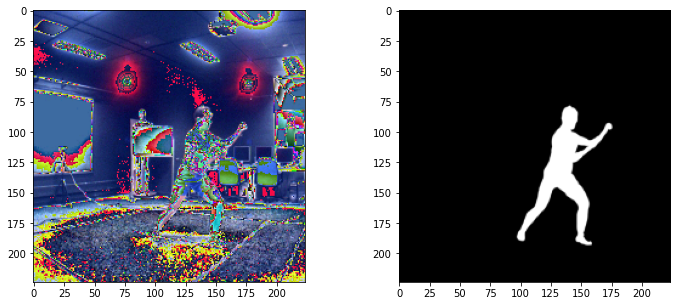

In [14]:
train_features, train_labels = next(iter(train_dl))
ra = random.randint(0, 7)
print(train_features.shape, train_labels.shape)
print_image(train_features[ra], train_labels[ra])

In [15]:
def convrelu(in_channels, out_channels, kernel=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

In [16]:
class UnetModelResNet(nn.Module):
    #Unet model based on pretrained Restnet 18
    def __init__(self, n_class=1):
        super(UnetModelResNet, self).__init__()
        
        self.resnet_model = torchvision.models.resnet18(pretrained=True)
        self.resnet_layers = list(self.resnet_model.children())
        
        for param in self.resnet_model.parameters():
            param.requires_grad = False
        
        self.block0 = nn.Sequential(*self.resnet_layers[:3])
        self.block0_1x1 = convrelu(64, 64)
        self.block1 = nn.Sequential(*self.resnet_layers[3:5])
        self.block1_1x1 = convrelu(64, 64)
        self.block2 = nn.Sequential(*self.resnet_layers[5])
        self.block2_1x1 = convrelu(128, 128)
        self.block3 = nn.Sequential(*self.resnet_layers[6])
        self.block3_1x1 = convrelu(256, 256)
        self.block4 = nn.Sequential(*self.resnet_layers[7])
        self.block4_1x1 = convrelu(512, 512)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = torch.nn.ReLU() 
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1, padding=0)
        
    def forward(self, x):
        x_original = self.conv_original_size0(x)
        x_original = self.conv_original_size1(x_original)
        
        
        block0 = self.block0(x)
        block1 = self.block1(block0)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        
        block4 = self.block4_1x1(block4)
        x = self.upsample(block4)
        block3 = self.block3_1x1(block3)
        x = torch.cat([x, block3], dim=1)
        x = self.conv_up3(x)
        
        x = self.upsample(x)
        block2 = self.block2_1x1(block2)
        x = torch.cat([x, block2], dim=1)
        x = self.conv_up2(x)
        
        x = self.upsample(x)
        block1 = self.block1_1x1(block1)
        x = torch.cat([x, block1], dim=1)
        x = self.conv_up1(x)
        
        x = self.upsample(x)
        block0 = self.block0_1x1(block0)
        x = torch.cat([x, block0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out
        
        
       

In [17]:
model = UnetModelResNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

device:  cuda


In [18]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

In [20]:
def ioU_metric(predicted, ground_truth, threshold = 0.5, smooth=1):
    predicted = (predicted > threshold)
    intersection = (predicted * threshold).sum(dim=(1,2,3))
    union = predicted.sum(dim=(1,2,3)) + ground_truth.sum(dim=(1,2,3)) - intersection
    iou =  ((intersection + smooth) / (union + smooth)).mean()
    return iou.item()

def f1_metric(predicted, ground_truth, threshold = 0.5, smooth=1):
    predicted = (predicted > threshold)
    intersection = (predicted * threshold).sum(dim=(1,2,3))
    union = predicted.sum(dim=(1,2,3)) + ground_truth.sum(dim=(1,2,3)) - intersection
    f1 = ((2.0 * intersection + smooth) / (smooth + union)).mean()
    return f1.item()

In [21]:
def train_model(model, optimizer, loss, scheduler, num_epoch=1, batch_size=8):

    dataloaders = {
        'train': train_dl,
        'val': valid_dl
    }

    best_loss = 1e9
    best_model = copy.deepcopy(model.state_dict())
    
    history = {'train' : [],
               'val' : []}
    
    iou_metric = { 
            'train' : [],
            'val' : []}
    
    f1metric = { 
            'train' : [],
            'val' : []}
    
    epoch_samples = 0
    m = torch.nn.Sigmoid()
    
    for epoch in range(num_epoch):
        print('Epoch {}/{} \n'.format(epoch + 1, num_epoch))
        print('-' * 10)
        time_start = time.time()
        
        
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_iou = 0.0
            running_f1 = 0.0
            
            
            for inputs, labels in dataloaders[phase]:#tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(float).to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    #forward
                    outputs = model(inputs)
                    loss_value = loss(m(outputs).to(float), labels)
                    
                    #backward
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                
                running_loss += loss_value.data.cpu().numpy()
                running_iou += ioU_metric(outputs, labels)
                running_f1 += f1_metric(outputs, labels)
                
                
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_iou = running_iou / len(dataloaders[phase])
            epoch_f1 = running_f1 / len(dataloaders[phase])
            
            
            print('{} Loss: {:.8f} '.format(phase, epoch_loss))
            history[phase].append(epoch_loss)
            iou_metric[phase].append(epoch_iou)
            f1metric[phase].append(epoch_f1)
            
            
            if phase == 'val' and best_loss > loss_value.item():
                best_loss = loss_value.item()
                best_model = copy.deepcopy(model.state_dict())
                torch.save(best_model, os.getcwd() + '/weights_best')
            
        time_check = time_start - time.time()
        print('{:.0f}m {:.0f}s'.format(time_check // 60, time_check % 60), flush=True)
        
    print('best loss : {}'.format(best_loss))
    model.load_state_dict(best_model)
        
    return model, history, iou_metric, f1metric
    
    
   

In [22]:
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epoch = 100

In [23]:
model, history, iou_metric, f1metric = train_model(model = model, optimizer = optimizer, loss = loss, scheduler = scheduler, num_epoch=num_epoch);

Epoch 1/100 

----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.10915000 
val Loss: 0.03159706 
-1m 18s
Epoch 2/100 

----------
train Loss: 0.02836656 
val Loss: 0.02368572 
-1m 18s
Epoch 3/100 

----------
train Loss: 0.02310275 
val Loss: 0.02058605 
-1m 18s
Epoch 4/100 

----------
train Loss: 0.02010124 
val Loss: 0.01935170 
-1m 18s
Epoch 5/100 

----------
train Loss: 0.01870768 
val Loss: 0.01733736 
-1m 19s
Epoch 6/100 

----------
train Loss: 0.01816016 
val Loss: 0.01766913 
-1m 18s
Epoch 7/100 

----------
train Loss: 0.01784911 
val Loss: 0.01729060 
-1m 18s
Epoch 8/100 

----------
train Loss: 0.01791751 
val Loss: 0.01720347 
-1m 19s
Epoch 9/100 

----------
train Loss: 0.01758541 
val Loss: 0.01722383 
-1m 19s
Epoch 10/100 

----------
train Loss: 0.01757045 
val Loss: 0.01700662 
-1m 19s
Epoch 11/100 

----------
train Loss: 0.01733654 
val Loss: 0.01659692 
-1m 19s
Epoch 12/100 

----------
train Loss: 0.01740515 
val Loss: 0.01683094 
-1m 19s
Epoch 13/100 

----------
train Loss: 0.01723177 
val Loss: 0.01647075 
-1

In [24]:
def plot_graphs(num_epoch, history, act):
    x = np.arange(num_epoch)
    plt.plot(x, history['train'],label = 'train', )
    plt.plot(x, history['val'], label = 'validation', )
    plt.title(f'{act} while training/validation')
    plt.xlabel('Epoch')
    plt.ylabel(act)
    plt.legend()
    plt.show()
    return

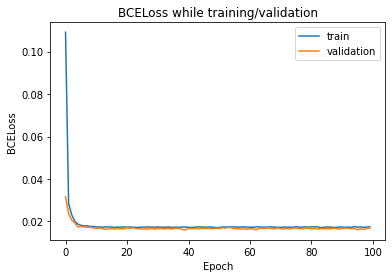

In [25]:
plot_graphs(num_epoch, history, 'BCELoss')

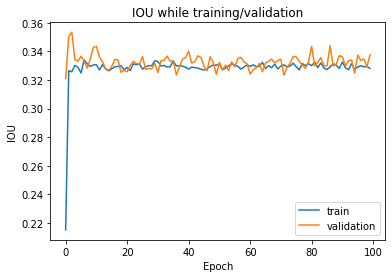

In [26]:
plot_graphs(num_epoch,  iou_metric, 'IOU')


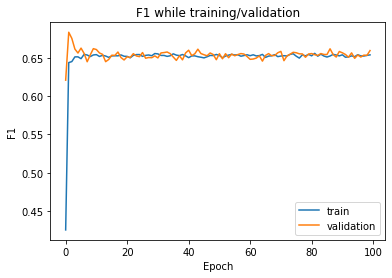

In [27]:
plot_graphs(num_epoch,  f1metric, 'F1')

In [28]:
def predict(model, inputs):
    inputs = torch.unsqueeze(inputs, dim=0)
    pred = model(inputs.to(device))
    return torch.squeeze(pred, 0)

In [29]:
import urllib.request
image_url = "https://cdn3.whatculture.com/images/2021/08/5e21602b99b1ba27-600x338.jpeg"
image_name = 'picture.jpg'

urllib.request.urlretrieve(image_url, image_name)

('picture.jpg', <http.client.HTTPMessage at 0x7f51d81a8c10>)

In [30]:
image = read_image('./' + image_name)

In [31]:
img_reshaped = image.permute(1, 2, 0)

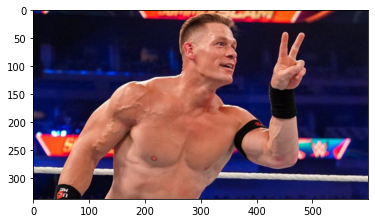

In [32]:
plt.imshow(img_reshaped)

In [33]:
ima, _ = transform(image, torch.rand((1,1,224,224)))

In [34]:
pre = predict(model, ima).detach().cpu().permute(1,2,0).numpy()

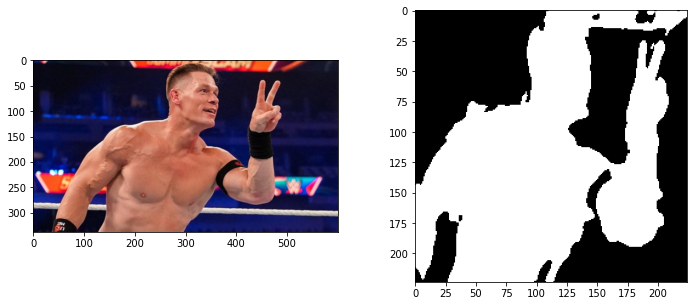

In [35]:
print_image(img_reshaped.numpy(), pre > 0.5)